In [1]:
import numpy as np
import scipy.optimize as spo
import scipy.stats as sps
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn import datasets as skl_datasets
from sklearn import linear_model as skl_lm
from sklearn import model_selection as skl_ms



In [3]:
# (1.1.6) & (1.1.7)

def ols(y, X):
    return np.linalg.solve(X.T @ X, X.T @ y)

def ssr(b, y, X):
    e = y - X @ b
    return e.T @ e

def ols_numerical(y, X):
    return spo.minimize(lambda b: ssr(b, y, X), np.zeros(X.shape[1])).x

def ols_sm(y, X):
    mod = sm.OLS(y, X)
    res = mod.fit()
    return res.params


np.random.seed(5673452)
X = np.random.normal(size = (100, 4))
y = np.random.normal(size = (100))

print(np.sum(np.abs(ols(y, X) - ols_numerical(y, X))),
np.sum(np.abs(ols(y, X) - ols_sm(y, X)))
      )

3.380015379736423e-08 5.065392549852277e-16


In [70]:
# (1.2.4)

np.random.seed(4526453)
M = 5000
n = 500
beta = np.array([1.0, 2.0])
X = np.random.normal(size = (n, len(beta)))

### Verify X is of full rank
# np.linalg.eigvalsh(X.T @ X)

Xbeta = X @ beta
estimates = np.zeros((M, len(beta)))

for m in range(M):
    y = Xbeta + np.random.normal(size = n)
    estimates[m, :] = ols(y, X).T

print(beta)
print(estimates.mean(axis = 0))

print("\n")

print(np.linalg.solve(X.T @ X, np.eye(2)))
print(np.cov(estimates.T))

[1. 2.]
[0.99984777 2.0012884 ]


[[ 0.00188761 -0.00016124]
 [-0.00016124  0.00182909]]
[[ 0.00186542 -0.00022051]
 [-0.00022051  0.00179447]]


In [5]:
# (1.2.7)

def gls(y, X, V):
    return np.linalg.solve(
        X.T @ np.linalg.solve(V, X),
        X.T @ np.linalg.solve(V, y)
        )

np.random.seed(4526453)
M = 5000
n = 500
beta = np.array([1.0, 2.0])
X = np.random.normal(size = (n, len(beta)))

### Verify X is of full rank
# np.linalg.eigvalsh(X.T @ X)

V = np.diag(np.linalg.norm(X, axis = 1))
Xbeta = X @ beta
OLS = np.zeros((M, len(beta)))
GLS = np.zeros((M, len(beta)))

for m in range(M):
    y = Xbeta + V @ np.random.normal(size = n)
    OLS[m, :] = ols(y, X).T
    GLS[m, :] = gls(y, X, V).T

Delta = np.cov(OLS.T) - np.cov(GLS.T)
np.linalg.eigvalsh(Delta)

array([0.00262519, 0.00326152])

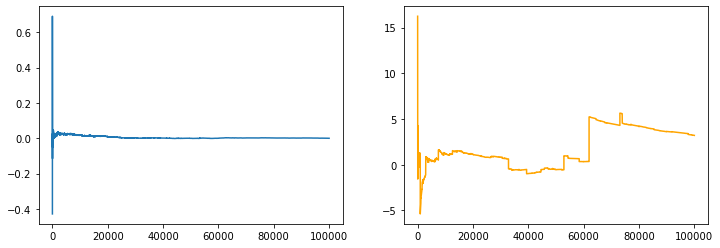

In [6]:
# (1.2.11)

np.random.seed(908452)
M = 100000
denom = np.arange(1, M+1)
X = np.random.normal(size = M).cumsum() / denom
Y = np.random.standard_cauchy(size = M).cumsum() / denom

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
ax1.plot(denom, X)
ax2.plot(denom, Y, color = "orange")
plt.show()

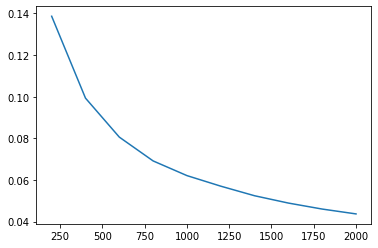

In [14]:
# (1.2.12)

np.random.seed(5625)
M = 5000
ns = [200 *i for i in range(1, 11)]

beta = np.random.uniform(size = 2)
Sigma = np.array([[1.0, 0.7], [0.7, 1.0]])

betas = np.zeros(len(ns))
out = np.zeros(M)

for (i, n) in enumerate(ns):    
    
    for m in range(M):

        X = np.random.multivariate_normal(np.zeros(len(beta)), Sigma, size = n)
        e = np.random.standard_t(8, size = n)
        y = X @ beta + e
        out[m] = np.linalg.norm(ols(y, X) - beta)

    betas[i] = out.mean()

fig, ax = plt.subplots()
ax.plot(ns, betas)
plt.xlabel(r"$n$")
plt.ylabel(r"$\|\hat\beta_n - \beta\|$")
plt.show()

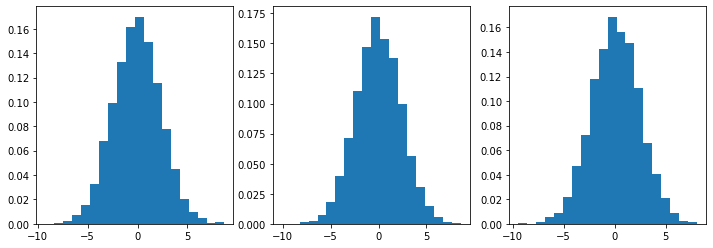

In [53]:
# (1.2.13)

np.random.seed(5625)
M = 5000
ns = [400 *i for i in range(1, 4)]

beta = np.random.uniform(size = (1, 1))
Sigma = 0.7

betas = np.zeros((len(ns), M))

for (i, n) in enumerate(ns):
    for m in range(M):
        X = np.random.normal(loc = 0, scale = Sigma, size = (n, 1))
        e = np.random.standard_t(8, size = (n, 1))
        y = X @ beta + e
        betas[i, m] = ols(y, X)


# # (i) histogram plots of \hat\beta_n
# fig, axs = plt.subplots(1, 3, figsize = (12, 4))
# for (i, n) in enumerate(ns):
#     axs[i].hist(betas[i, :], bins = 20, density = True)
# plt.show()
#
# # (ii) histogram plots of \hat\beta_n - beta
# diff = betas - beta
# fig, axs = plt.subplots(1, 3, figsize = (12, 4))
# for (i, n) in enumerate(ns):
#     axs[i].hist(diff[i, :], bins = 20, density = True)
# plt.show()

# (iii) histogram plots of \sqrt{n}(\hat\beta_n - beta)
diff = betas - beta
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
for (i, n) in enumerate(ns):
    scaled = n**(1/2) * diff[i, :]
    axs[i].hist(scaled, bins = 20, density = True)
plt.show()

In [4]:
# (1.12.25)

np.random.seed(56253)
M = 5000
n = 400

alpha = 0.05
cv = sps.chi2(1).ppf(1-alpha)

beta = np.zeros((1,1))
Sigma = 0.7

rej = 0
for m in range(M):
    X = np.random.normal(0, Sigma, size = (n, 1))
    e = np.random.standard_t(8, size = (n, 1))
    y = X @ beta + e

    beta_hat = ols(y, X)
    e_hat = y - X @ beta_hat
    
    # Conditionally homoskedastic estimator
    # sigma_hat = (e_hat**2).mean()
    # Omega_hat = sigma_hat * np.linalg.solve((X.T @ X / n), np.eye(len(beta)))

    M_hat = (X**2).mean()
    Sigma_hat = ((e_hat * X)**2).mean()
    Omega_hat = M_hat**(-2) * Sigma_hat 
     
    W = n * beta_hat**2 / Omega_hat
    rej += (W[0,0] > cv)

rej / M * 100

5.62

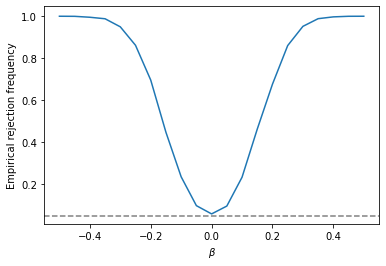

In [5]:
# (1.12.26)

np.random.seed(56253)
M = 5000
n = 400

alpha = 0.05
cv = sps.chi2(1).ppf(1-alpha)

beta0 = np.zeros((1,1))
Sigma = 0.7

alternatives = np.linspace(-0.5, 0.5, 21)
rej = np.zeros(len(alternatives))

for (i, beta1) in enumerate(alternatives):
    beta = np.array([beta1]).reshape((1, 1))
    for m in range(M):
        X = np.random.normal(0, Sigma, size = (n, 1))
        e = np.random.standard_t(8, size = (n, 1))
        y = X @ beta + e

        beta_hat = ols(y, X)
        e_hat = y - X @ beta_hat
        
        # Conditionally homoskedastic estimator
        # sigma_hat = (e_hat**2).mean()
        # Omega_hat = sigma_hat * np.linalg.solve((X.T @ X / n), np.eye(len(beta)))

        M_hat = (X**2).mean()
        Sigma_hat = ((e_hat * X)**2).mean()
        Omega_hat = M_hat**(-2) * Sigma_hat 
        
        W = n * beta_hat**2 / Omega_hat
        rej[i] += (W[0,0] > cv)

rej /= M

fig, ax = plt.subplots()
ax.plot(alternatives, rej)
ax.axhline(0.05, linestyle = "--", color = "black", alpha = 0.5)
plt.xlabel(r"$\beta$")
plt.ylabel("Empirical rejection frequency")
plt.show()


In [31]:
# (1.2.27)
df = sm.datasets.star98.load_pandas().data
res = smf.ols("NABOVE ~ LOWINC + AVYRSEXP + PERSPENK + PTRATIO", data = df).fit()
print(res.summary())
W1 = res.wald_test(np.array([0, 1, 0, 0, 0]), use_f = False, scalar = True).statistic
W2 = res.wald_test(np.hstack((np.zeros((4,1)), np.eye(4))), use_f = False, scalar = True).statistic
print(W1 > sps.chi2(1).ppf(0.95), W2 > sps.chi2(4).ppf(0.95))

                            OLS Regression Results                            
Dep. Variable:                 NABOVE   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     5.602
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           0.000232
Time:                        18:40:05   Log-Likelihood:                -2386.0
No. Observations:                 303   AIC:                             4782.
Df Residuals:                     298   BIC:                             4801.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1309.9910    713.465     -1.836      0.0

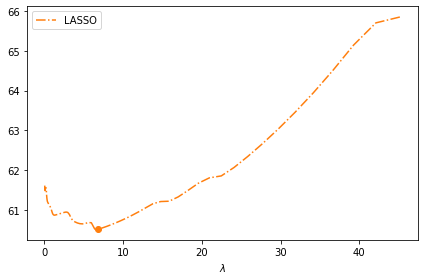

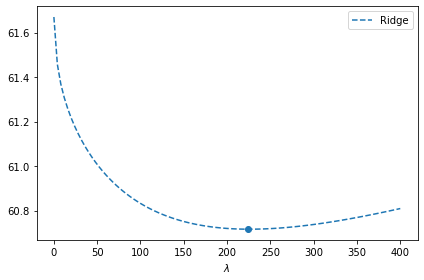

lasso beta =  [ 0.         -0.         23.79546748  8.69142511 -0.         -0.
 -5.01317558  0.         20.67777633  0.        ] 
 ridge beta =  [ 0.96733822 -6.19950427 18.17586473 11.61041211 -0.70133581 -2.75149153
 -8.2997453   5.80111004 15.56778817  5.28037228] 
 ols beta =  [ -0.47623169 -11.40703082  24.72625713  15.42967916 -37.68035801
  22.67648701   4.80620008   8.422084    35.73471316   3.21661161]


In [2]:
# (1.4.11)
X, y = skl_datasets.load_diabetes(return_X_y=True)
X /= X.std(axis=0) # normalise scales
n = y.shape[0]

# OLS
ols = skl_lm.LinearRegression(fit_intercept=False).fit(X, y)

# Lasso regression w/ LOOCCV chosen parameter 
lasso = skl_lm.LassoCV(fit_intercept=False, cv = skl_ms.LeaveOneOut()).fit(X, y)
lasso_cv = lasso.mse_path_.mean(axis = 1) / n
lambdas = lasso.alphas_

fig, ax = plt.subplots()
ax.plot(lambdas, lasso_cv, color = "tab:orange", linestyle = "-.", label = "LASSO")
ax.scatter(lasso.alpha_, lasso_cv[np.where(lasso.alpha_ == lambdas)[0][0]], color = "tab:orange")
plt.legend()
plt.xlabel(r"$\lambda$")
plt.tight_layout()
plt.show()

# Ridge regression w/ LOOCCV chosen parameter 
lambdas = np.linspace(0.01, 400, 101)
ridge = skl_lm.RidgeCV(lambdas, fit_intercept=False, store_cv_values=True).fit(X, y)
ridge_cv = ridge.cv_values_.mean(axis = 0) / n

fig, ax = plt.subplots()
ax.plot(lambdas, ridge_cv, color = "tab:blue", linestyle = "--", label = "Ridge")
ax.scatter(ridge.alpha_, ridge_cv[np.where(ridge.alpha_ == lambdas)[0][0]], color = "tab:blue")
plt.legend()
plt.xlabel(r"$\lambda$")
plt.tight_layout()
plt.show()

print("lasso beta = ",  lasso.coef_, "\n", "ridge beta = ", ridge.coef_, "\n", "ols beta = ", ols.coef_)
